In [ ]:
GCS_PATH = "gs://kds-708f6da9f99dc2954ff2d86790f8c49a9b54f61bb7a60770b6f84a2e"
train_filenames = tf.io.gfile.glob(GCS_PATH + '/*train*.tfrec' )
train_filenames

In [ ]:
val_filenames = tf.io.gfile.glob(GCS_PATH + '/*val*.tfrec' )
val_filenames

## Setup

In [12]:
## prevent colab shutdown 
%%javascript
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

var connection = setInterval(ConnectButton, 60000);

function myStopFunction() {
    console.log("Remove interal"); 
    clearInterval(connection);
}

<IPython.core.display.Javascript object>

In [13]:
import os
import re
import sys
import glob
import json
import random
import sklearn
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib as mpl
from keras import backend as K
from tensorboard import notebook
import tensorflow as tf, re, math
from keras.optimizers import Adam
from tensorflow.keras import layers
from datetime import datetime, date
import matplotlib.pyplot as plt, cv2
from IPython.display import clear_output 
from sklearn.metrics import roc_curve, auc
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet101V2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, LearningRateScheduler

In [14]:
# remove the sample_data dir to free up disc space
os.system('rm -rf /content/sample_data')

# remove old submission files
os.system('rm /content/submission.csv')

# remove all caches
for file in glob.glob('/content/cache*'): 
    os.remove(file)

# remove old checkpoint files
for file in glob.glob('/content/*.hdf5'): 
    os.remove(file)

# check were the kaggle auth file is stored
path_to_auth_file = "kaggle.json"
if not os.path.exists(path_to_auth_file):
    path_to_auth_file = '/content/drive/MyDrive/Colab Notebooks/_auth/kaggle.json'

# read the kaggle.json file
with open(path_to_auth_file) as json_file:
    data = json.load(json_file)
    os.environ['KAGGLE_USERNAME'] = data["username"]
    os.environ['KAGGLE_KEY'] = data["key"]

# download data if the have to
if not os.path.exists("/content/data/test.csv"):
    print("Download data")
    os.system('mkdir data')

    # go to data directory and download dataset
    os.system(
        'cd data && kaggle datasets download -d cdeotte/jpeg-melanoma-768x768'
    )
    
    print("Unzip data")
    # unzip the zip file
    os.system('cd data && unzip -o jpeg-melanoma-768x768')

    # remove the not needed files
    os.system('cd data && rm jpeg-melanoma-768x768.zip')

clear_output()

In [15]:
SEED = 1
DIM = 768
EPOCHS = 30
BATCH_SIZE = 16
NUM_CLASSES = 1
VERBOSE_LEVEL = 1
SAVE_OUTPUT = True
BASE_PATH = "/content/data"

# suppress tf logs and warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(2)

# seed everything
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_KERAS'] = str(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)

# Tensorflow execution optimizations
# Source: https://www.tensorflow.org/guide/mixed_precision & https://www.tensorflow.org/xla
print("Tensorflow version " + tf.__version__)
strategy = tf.distribute.get_strategy()
num_gpus = len(
    tf.config.experimental.list_physical_devices('GPU')
)

if num_gpus > 0:
    print("Num GPUs Available: ", num_gpus)
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')


strategy = tf.distribute.get_strategy()
REPLICAS = strategy.num_replicas_in_sync
AUTOTUNE = tf.data.AUTOTUNE

print("Using default strategy for CPU and single GPU")
print("REPLICAS:", REPLICAS)
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1
Num GPUs Available:  1
Mixed precision enabled
Accelerated Linear Algebra enabled
Using default strategy for CPU and single GPU
REPLICAS: 1
Tensorflow version 2.4.1


## Prepare Dataset

In [16]:
def check_image_paths(file_path):
    """ Helper function to validate the image paths

    Parameters:
        file_path (string): Path to the image

    Returns:
        The file path if the file exists, otherwise false if the file does not exist

    """
    img_file = Path(file_path)
    if img_file.is_file():
        return file_path
    return False


def get_train_data(base_path, image_path, image_type):
    """ Helper function to get the train dataset
    """
    # read the data from the train.csv file
    train = pd.read_csv(os.path.join(base_path, 'train.csv'))
    # add the image_path to the train set
    train['image_path'] = train['image_name'].apply(
        lambda x: image_path + "/train/" + x + image_type)
    # check if the we have an image
    train['image_path'] = train.apply(
        lambda row: check_image_paths(row['image_path']), axis=1)
    # if we do not have an image we will not include the data
    train = train[train['image_path'] != False]
    print("valid rows in train", train.shape[0])
    return train


def get_test_data(base_path, image_path, image_type):
    """ Helper function to get the test dataset
    """
    test = pd.read_csv(os.path.join(base_path, 'test.csv'))
    test['image_path'] = test['image_name'].apply(
        lambda x: image_path + "/test/" + x + image_type)
    test['image_path'] = test.apply(
        lambda row: check_image_paths(row['image_path']), axis=1)
    test = test[test['image_path'] != False]
    print("valid rows in test", test.shape[0])
    return test


def prepare_data(train, test):
    # getting dummy variables for gender
    sex_dummies = pd.get_dummies(train['sex'], prefix='sex', dtype="int")
    train = pd.concat([train, sex_dummies], axis=1)

    sex_dummies = pd.get_dummies(test['sex'], prefix='sex', dtype="int")
    test = pd.concat([test, sex_dummies], axis=1)

    # getting dummy variables for anatom_site_general_challenge
    anatom_dummies = pd.get_dummies(
        train['anatom_site_general_challenge'], prefix='anatom', dtype="int")
    train = pd.concat([train, anatom_dummies], axis=1)

    anatom_dummies = pd.get_dummies(
        test['anatom_site_general_challenge'], prefix='anatom', dtype="int")
    test = pd.concat([test, anatom_dummies], axis=1)

    # getting dummy variables for target column
    target_dummies = pd.get_dummies(
        train['target'], prefix='target', dtype="int")
    train = pd.concat([train, target_dummies], axis=1)

    # dropping not useful columns
    train.drop(['sex', 'diagnosis', 'benign_malignant',
                'anatom_site_general_challenge'], axis=1, inplace=True)
    test.drop(['sex', 'anatom_site_general_challenge'], axis=1, inplace=True)

    # replace missing age values wiht the mean age
    train['age_approx'] = train['age_approx'].fillna(
        np.mean(train['age_approx']))
    test['age_approx'] = test['age_approx'].fillna(
        np.mean(test['age_approx']))

    # convert age and patient_id to int
    train['age_approx'] = train['age_approx'].astype('int')
    test['age_approx'] = test['age_approx'].astype('int')

    train = train.rename(columns={
        'anatom_head/neck': 'anatom_head_neck', 
        'anatom_lower extremity': 'anatom_lower_extremity',
        'anatom_oral/genital': 'anatom_oral_genital', 
        'anatom_palms/soles': 'anatom_palms_soles',
        'anatom_upper extremity': 'anatom_upper_extremity', 
    })

    test = test.rename(columns={
        'anatom_head/neck': 'anatom_head_neck', 
        'anatom_lower extremity': 'anatom_lower_extremity',
        'anatom_oral/genital': 'anatom_oral_genital', 
        'anatom_palms/soles': 'anatom_palms_soles',
        'anatom_upper extremity': 'anatom_upper_extremity', 
    })

    print("rows in train", train.shape[0])
    print("rows in test", test.shape[0])

    return train, test


def get_datasets(base_path, image_path, image_type, prepare_df):
    print("get train data")
    train_set = get_train_data(base_path, image_path, image_type)

    print("get test data")
    test_set = get_test_data(base_path, image_path, image_type)

    print("preparing datasets")
    if prepare_df:
        train_set, test_set = prepare_data(train_set, test_set)

    return train_set, test_set


def balance_dataset(df, balance=1):
    # Balance the dataset¶
    # 1 means 50 / 50 => equal amount of positive and negative cases in Training
    # 4 = 20%; 8 = ~11%; 12 = ~8%

    p_inds = df[df.target == 1].index.tolist()
    np_inds = df[df.target == 0].index.tolist()

    np_sample = random.sample(np_inds, balance * len(p_inds))
    df = df.loc[p_inds + np_sample]
    print("Samples in df", df['target'].sum()/len(df))
    print("Remaining rows in df set", len(df))
    return df


def create_splits(df, test_size, classToPredict, seed):
    train_data, val_data = train_test_split(
        df,  test_size=test_size, random_state=seed, stratify=df[classToPredict])

    return train_data, val_data

In [17]:
def _parse_function(filename, label):
    """Obtain the image from the filename (for both training and validation).
    The following operations are applied:
        - Decode the image from jpeg format
        - Convert to float and to range [0, 1]
    """
    image_string = tf.io.read_file(filename)

    # Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)

    ## This will convert to float values in [0, 1]
    #image = tf.image.convert_image_dtype(image_decoded, tf.float32)

    resized_image = tf.image.resize(image, [DIM, DIM])

    return resized_image, label


def input_fn(is_training, filenames, labels):
    """Input function
    Args:
        is_training: (bool) whether to use the train or test pipeline.
                     At training, we shuffle the data and have multiple epochs
        filenames: (list) filenames of the images, as ["data_dir/{label}_IMG_{id}.jpg"...]
        labels: (list) corresponding list of labels
    """
    num_samples = len(filenames)
    assert len(filenames) == len(labels), "Filenames and labels should have same length"

    # Create a Dataset serving batches of images and labels
    parse_fn = lambda f, l: _parse_function(f, l)

    if is_training:
        dataset = (tf.data.Dataset.from_tensor_slices((tf.constant(filenames), tf.constant(labels)))
            .cache()
            .shuffle(num_samples)  # whole dataset into the buffer ensures good shuffling
            .map(parse_fn, num_parallel_calls=REPLICAS)
        )
    else:
        dataset = (tf.data.Dataset.from_tensor_slices((tf.constant(filenames), tf.constant(labels)))
            .cache()
            .map(parse_fn)
        )

    return dataset

In [18]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(15):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("MALIGNANT")
        else:
            plt.title("BENIGN")
        plt.axis("off")

In [19]:
train_set, test_set = get_datasets(BASE_PATH, BASE_PATH, ".jpg", True)

train_set_balanced = balance_dataset(train_set, 12)
train_set_balanced, validation_set_balanced = create_splits(train_set_balanced, 0.2, 'target', SEED)

print(" ")

print("Rows in train set", train_set_balanced.shape[0])
print("Rows in validation set", validation_set_balanced.shape[0])
print("Rows in test set", test_set.shape[0])

get train data
valid rows in train 33126
get test data
valid rows in test 10982
preparing datasets
rows in train 33126
rows in test 10982
Samples in df 0.07692307692307693
Remaining rows in df set 7592
 
Rows in train set 6073
Rows in validation set 1519
Rows in test set 10982


## TF Records

### Writing TF Records

Source: https://www.kaggle.com/cdeotte/how-to-create-tfrecords#Write-TFRecords---Train

In [ ]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
def serialize_example_train(
    image, 
    image_name, 
    patient_id, 
    sex_female, 
    sex_male, 
    image_path, 
    age_approx,
    anatom_head_neck,
    anatom_lower_extremity,
    anatom_oral_genital,
    anatom_palms_soles,
    anatom_torso,
    anatom_upper_extremity,
    target
 ):
  feature = {
        'image': _bytes_feature(image),
        'image_name': _bytes_feature(image_name),
        'patient_id': _bytes_feature(patient_id),
        'sex_female': _int64_feature(sex_female),
        'sex_male': _int64_feature(sex_male),
        'image_path': _bytes_feature(image_path),
        'age_approx': _int64_feature(age_approx),
        'anatom_head_neck': _int64_feature(anatom_head_neck),
        'anatom_lower_extremity': _int64_feature(anatom_lower_extremity),
        'anatom_oral_genital': _int64_feature(anatom_oral_genital),
        'anatom_palms_soles': _int64_feature(anatom_palms_soles),
        'anatom_torso': _int64_feature(anatom_torso),
        'anatom_upper_extremity': _int64_feature(anatom_upper_extremity),
        'target': _int64_feature(target)
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [ ]:
def serialize_example_test(
    image, 
    image_name, 
    patient_id, 
    sex_female, 
    sex_male, 
    image_path, 
    age_approx,
    anatom_head_neck,
    anatom_lower_extremity,
    anatom_oral_genital,
    anatom_palms_soles,
    anatom_torso,
    anatom_upper_extremity
 ):
  feature = {
        'image': _bytes_feature(image),
        'image_name': _bytes_feature(image_name),
        'patient_id': _bytes_feature(patient_id),
        'sex_female': _int64_feature(sex_female),
        'sex_male': _int64_feature(sex_male),
        'image_path': _bytes_feature(image_path),
        'age_approx': _int64_feature(age_approx),
        'anatom_head_neck': _int64_feature(anatom_head_neck),
        'anatom_lower_extremity': _int64_feature(anatom_lower_extremity),
        'anatom_oral_genital': _int64_feature(anatom_oral_genital),
        'anatom_palms_soles': _int64_feature(anatom_palms_soles),
        'anatom_torso': _int64_feature(anatom_torso),
        'anatom_upper_extremity': _int64_feature(anatom_upper_extremity)
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

### Create Train & Val Records

In [ ]:
!rm -rf tfrecords
!mkdir tfrecords

In [ ]:
SIZE = 200
IMGS = train_set_balanced.shape[0]
TF_Record_Files = IMGS//SIZE + int(IMGS%SIZE!=0)

for i in range(TF_Record_Files):
    print()
    print('Writing TFRecord', i + 1 , 'of', TF_Record_Files)
    Images_In_TF_Records = min(SIZE, IMGS - i * SIZE)
    print('Images_In_TF_Records', Images_In_TF_Records)
    with tf.io.TFRecordWriter('tfrecords/train%.2i-%i.tfrec'%(i, Images_In_TF_Records)) as writer:
        for k in range(Images_In_TF_Records):
            offset = SIZE * i
            row = train_set_balanced.iloc[offset + k] ## get row image_path in df
            image_path = row['image_path'] ## get row image_path in df
            img = cv2.imread(image_path)
            #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # fix incorrect colors
            img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 94))[1].tostring()
            example = serialize_example_train(
                img, 
                str.encode(row['image_name']), 
                str.encode(row['patient_id']),
                row['sex_female'], 
                row['sex_male'], 
                str.encode(row['image_path']),
                row['age_approx'],
                row['anatom_head_neck'],
                row['anatom_lower_extremity'],
                row['anatom_oral_genital'],
                row['anatom_palms_soles'],
                row['anatom_torso'],
                row['anatom_upper_extremity'],
                row['target']
            )
            writer.write(example)
            if k%100==0: print(k,', ',end='')


Writing TFRecord 1 of 31
Images_In_TF_Records 200
0 , 100 , 
Writing TFRecord 2 of 31
Images_In_TF_Records 200
0 , 100 , 
Writing TFRecord 3 of 31
Images_In_TF_Records 200
0 , 100 , 
Writing TFRecord 4 of 31
Images_In_TF_Records 200
0 , 100 , 
Writing TFRecord 5 of 31
Images_In_TF_Records 200
0 , 100 , 
Writing TFRecord 6 of 31
Images_In_TF_Records 200
0 , 100 , 
Writing TFRecord 7 of 31
Images_In_TF_Records 200
0 , 100 , 
Writing TFRecord 8 of 31
Images_In_TF_Records 200
0 , 100 , 
Writing TFRecord 9 of 31
Images_In_TF_Records 200
0 , 100 , 
Writing TFRecord 10 of 31
Images_In_TF_Records 200
0 , 100 , 
Writing TFRecord 11 of 31
Images_In_TF_Records 200
0 , 100 , 
Writing TFRecord 12 of 31
Images_In_TF_Records 200
0 , 100 , 
Writing TFRecord 13 of 31
Images_In_TF_Records 200
0 , 100 , 
Writing TFRecord 14 of 31
Images_In_TF_Records 200
0 , 100 , 
Writing TFRecord 15 of 31
Images_In_TF_Records 200
0 , 100 , 
Writing TFRecord 16 of 31
Images_In_TF_Records 200
0 , 100 , 
Writing TFRecord

In [ ]:
SIZE = 200
IMGS = validation_set_balanced.shape[0]
TF_Record_Files = IMGS//SIZE + int(IMGS%SIZE!=0)

for i in range(TF_Record_Files):
    print()
    print('Writing TFRecord', i + 1 , 'of', TF_Record_Files)
    Images_In_TF_Records = min(SIZE, IMGS - i * SIZE)
    print('Images_In_TF_Records', Images_In_TF_Records)
    with tf.io.TFRecordWriter('tfrecords/val%.2i-%i.tfrec'%(i, Images_In_TF_Records)) as writer:
        for k in range(Images_In_TF_Records):
            offset = SIZE * i
            row = validation_set_balanced.iloc[offset + k] ## get row image_path in df
            image_path = row['image_path'] ## get row image_path in df
            img = cv2.imread(image_path)
            #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # fix incorrect colors
            img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 94))[1].tostring()
            example = serialize_example_train(
                img, 
                str.encode(row['image_name']), 
                str.encode(row['patient_id']),
                row['sex_female'], 
                row['sex_male'], 
                str.encode(row['image_path']),
                row['age_approx'],
                row['anatom_head_neck'],
                row['anatom_lower_extremity'],
                row['anatom_oral_genital'],
                row['anatom_palms_soles'],
                row['anatom_torso'],
                row['anatom_upper_extremity'],
                row['target']
            )
            writer.write(example)
            if k%100==0: print(k,', ',end='')


Writing TFRecord 1 of 8
Images_In_TF_Records 200
0 , 100 , 
Writing TFRecord 2 of 8
Images_In_TF_Records 200
0 , 100 , 
Writing TFRecord 3 of 8
Images_In_TF_Records 200
0 , 100 , 
Writing TFRecord 4 of 8
Images_In_TF_Records 200
0 , 100 , 
Writing TFRecord 5 of 8
Images_In_TF_Records 200
0 , 100 , 
Writing TFRecord 6 of 8
Images_In_TF_Records 200
0 , 100 , 
Writing TFRecord 7 of 8
Images_In_TF_Records 200
0 , 100 , 
Writing TFRecord 8 of 8
Images_In_TF_Records 119
0 , 100 , 

In [ ]:
SIZE = 200
IMGS = test_set.shape[0]
TF_Record_Files = IMGS//SIZE + int(IMGS%SIZE!=0)

for i in range(TF_Record_Files):
    print()
    print('Writing TFRecord', i + 1 , 'of', TF_Record_Files)
    Images_In_TF_Records = min(SIZE, IMGS - i * SIZE)
    print('Images_In_TF_Records', Images_In_TF_Records)
    with tf.io.TFRecordWriter('./tfrecords/test%.2i-%i.tfrec'%(i, Images_In_TF_Records)) as writer:
        for k in range(Images_In_TF_Records):
            offset = SIZE * i
            row = test_set.iloc[offset + k] ## get row image_path in df
            image_path = row['image_path'] ## get row image_path in df
            img = cv2.imread(image_path)
            #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # fix incorrect colors
            img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 94))[1].tostring()
            example = serialize_example_test(
                img, 
                str.encode(row['image_name']), 
                str.encode(row['patient_id']),
                row['sex_female'], 
                row['sex_male'], 
                str.encode(row['image_path']),
                row['age_approx'],
                row['anatom_head_neck'],
                row['anatom_lower_extremity'],
                row['anatom_oral_genital'],
                row['anatom_palms_soles'],
                row['anatom_torso'],
                row['anatom_upper_extremity']
            )
            writer.write(example)
            if k%100==0: print(k,', ',end='')

### Loading TF Records

In [ ]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    #image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [DIM, DIM, 3]) # explicit size needed for TPU
    return image

In [ ]:
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "target": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = example['target']
    return image, label # returns a dataset of (image, label) pairs

In [ ]:
def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [ ]:
def get_training_dataset(batch_size = BATCH_SIZE):
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [ ]:
def get_validation_dataset(batch_size = BATCH_SIZE):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE) # prefetch next batch while validation (autotune prefetch buffer size)
    return dataset

In [ ]:
def get_test_dataset(batch_size = BATCH_SIZE):
    dataset = load_dataset(TEST_FILENAMES, labeled=True)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE) # prefetch next batch while test (autotune prefetch buffer size)
    return dataset

### Verify TF Records

In [ ]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [ ]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)
CLASSES = [0,1]

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    #if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
    #    numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels


def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct


def display_one_image(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)


def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = 'Benign' if label == 0 else 'Malignant'
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_image(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [ ]:
TRAINING_FILENAMES = tf.io.gfile.glob('/content/tfrecords/train*.tfrec')

print('There are', len(TRAINING_FILENAMES) ,'train tf records')
print('There are', count_data_items(TRAINING_FILENAMES) ,'train images')

There are 31 train tf records
There are 6073 train images


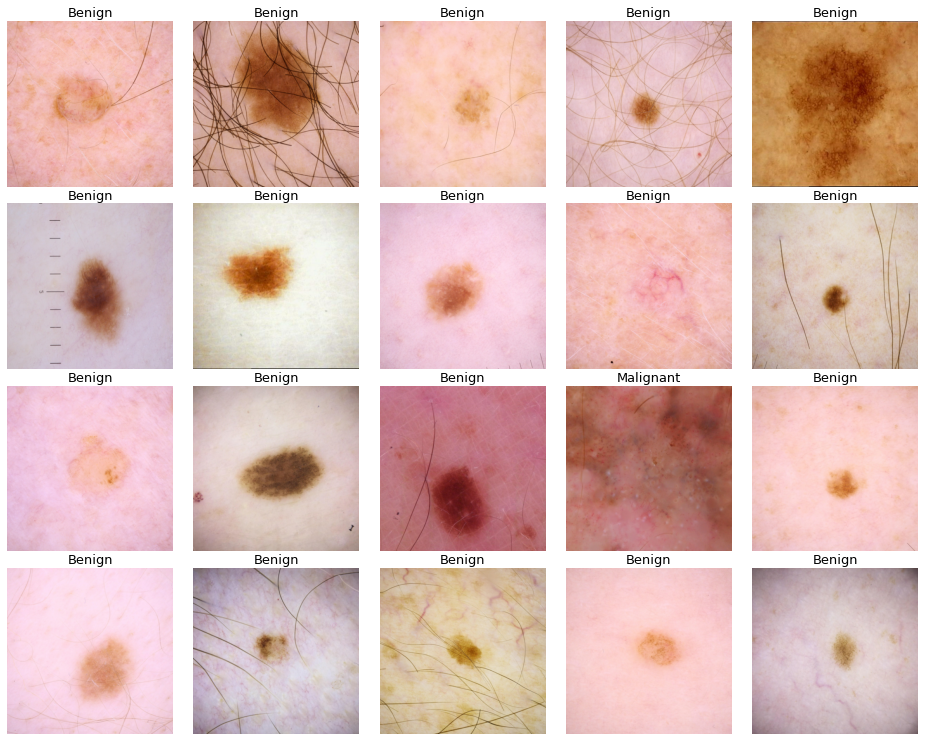

In [ ]:
example_dataset = get_training_dataset()
example_dataset = example_dataset.unbatch().batch(20)
example_batch = iter(example_dataset)
display_batch_of_images(next(example_batch))

In [ ]:
first_image = next(example_batch)[0][0]
print(np.min(first_image), np.max(first_image))
# The Pixel values are not normalized -> we have to do this when we will train the model

0 249


## Create Model

In [ ]:
def calc_f1(prec, recall):
    return 2*(prec*recall)/(prec+recall) if recall and prec else 0

def plot_roc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    fig, c_ax = plt.subplots(1, 1, figsize=(8, 8))
    c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % ('Target', auc(fpr, tpr)))
    c_ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn


def get_model_callbacks(verbose_level, save_output, timestamp):
    # model callbacks
    callback_list = []

    # if the model does not improve for 10 epochs, stop the training
    stop_early = EarlyStopping(
        monitor='val_loss',
        mode='auto',
        patience=10,
        restore_best_weights=True
    )
    callback_list.append(stop_early)

    # add tensorboard
    log_dir = "logs/fit/" + timestamp
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    callback_list.append(tensorboard_callback)

    ## learning rate decay
    exponential_decay_fn = exponential_decay(0.01, 20)
    lr_scheduler = LearningRateScheduler(exponential_decay_fn)
    callback_list.append(lr_scheduler)

    # if the output of the model should be saved, create a checkpoint callback function
    if save_output:
        # set the weight path for saving the model
        weight_path = "./" + timestamp + "-model.hdf5"
        # create the model checkpoint callback to save the model weights to a file
        checkpoint = ModelCheckpoint(
            weight_path,
            save_weights_only=True,
            verbose=verbose_level,
            save_best_only=True,
            monitor='val_loss',
            overwrite=True,
            mode='auto',
        )
        # append the checkpoint callback to the callback list
        callback_list.append(checkpoint)

    return callback_list

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [ ]:
base_model = tf.keras.applications.ResNet101V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(DIM, DIM, 3),
    include_top=False,
) 

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(DIM, DIM, 3))

# Apply random data augmentation
x = data_augmentation(inputs)  

# Each keras application expects a specific kind of input preprocessing. 
x = tf.keras.applications.resnet_v2.preprocess_input(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Regularize with dropout
x = tf.keras.layers.Dropout(0.2)(x) 

x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x) 

x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x) 

x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x) 

x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x) 

outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

## Model 1

In [ ]:
TRAINING_FILENAMES = tf.io.gfile.glob('/content/tfrecords/train*.tfrec')

print('There are', len(TRAINING_FILENAMES) ,'train tf records')
print('There are', count_data_items(TRAINING_FILENAMES) ,'train images')

print(" ")

VALIDATION_FILENAMES = tf.io.gfile.glob('/content/tfrecords/val*.tfrec')

print('There are', len(VALIDATION_FILENAMES) ,'val tf records')
print('There are', count_data_items(VALIDATION_FILENAMES) ,'val images')

training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()

There are 5 train tf records
There are 934 train images
 
There are 2 val tf records
There are 234 val images


In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

# make sure we do not init Tensorboard multiple times
# if callbacks is defined, a Tensorboard was already initialized
try:
    callbacks
except:
    # Load the TensorBoard notebook extension
    %load_ext tensorboard
    %tensorboard --logdir logs/fit
else:
    %reload_ext tensorboard   

In [ ]:
steps_per_epoch = count_data_items(TRAINING_FILENAMES)/BATCH_SIZE//REPLICAS
print("steps_per_epoch", steps_per_epoch)

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

# get the model callbacks
callbacks = get_model_callbacks(VERBOSE_LEVEL, SAVE_OUTPUT, timestamp)

steps_per_epoch 58.0


In [ ]:
OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy'
METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
] 

In [ ]:
# when creating multiple models, each model adds nodes to the graph
# best to clear the nodes to prevent memory hogging, which slows down training
K.clear_session()
with strategy.scope():
    model.summary()
    model.compile(
        loss=LOSS,
        metrics=METRICS,
        optimizer=OPTIMIZER,
    )

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 768, 768, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 768, 768, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 768, 768, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 768, 768, 3)       0         
_________________________________________________________________
resnet101v2 (Functional)     (None, 24, 24, 2048)      42626560  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [ ]:
history = model.fit(
    training_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    verbose=VERBOSE_LEVEL
)

Epoch 1/30
58/58 [==============================] - 55s 638ms/step - loss: 12.1311 - tp: 128.6102 - fp: 113.8814 - tn: 126.0847 - fn: 111.1525 - accuracy: 0.5249 - precision: 0.5236 - recall: 0.5798 - auc: 0.4964 - val_loss: 0.6134 - val_tp: 81.0000 - val_fp: 28.0000 - val_tn: 89.0000 - val_fn: 36.0000 - val_accuracy: 0.7265 - val_precision: 0.7431 - val_recall: 0.6923 - val_auc: 0.8281

Epoch 00001: val_loss improved from inf to 0.61340, saving model to ./2021-02-25_17:36:44-model.hdf5
Epoch 2/30
58/58 [==============================] - 33s 573ms/step - loss: 0.6325 - tp: 164.4068 - fp: 78.1356 - tn: 168.7797 - fn: 68.4068 - accuracy: 0.6828 - precision: 0.6522 - recall: 0.6883 - auc: 0.7218 - val_loss: 0.5320 - val_tp: 92.0000 - val_fp: 32.0000 - val_tn: 85.0000 - val_fn: 25.0000 - val_accuracy: 0.7564 - val_precision: 0.7419 - val_recall: 0.7863 - val_auc: 0.8307

Epoch 00002: val_loss improved from 0.61340 to 0.53197, saving model to ./2021-02-25_17:36:44-model.hdf5
Epoch 3/30
58/5

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8, 1])
    else:
      plt.ylim([0,1])

    plt.legend()

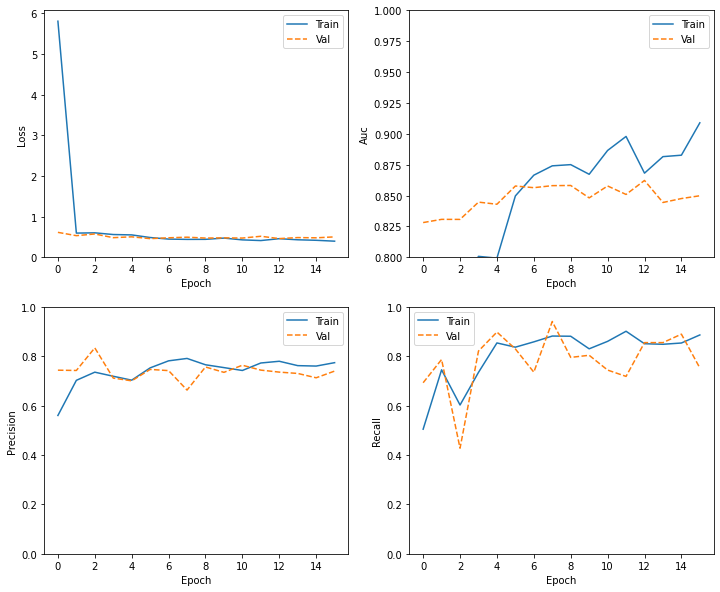

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
plot_metrics(history)

In [ ]:
y_t = []  # true labels
y_p = []  # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(validation_set_balanced.shape[0])):
    y_true = validation_set_balanced.iloc[i].target_1
    image_path = validation_set_balanced.iloc[i].image_path

    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(DIM,DIM))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)

    y_t.append(y_true)
    y_p.append(y_pred[0][0])

100%|██████████| 234/234 [00:26<00:00,  8.98it/s]


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_t, y_p)
f1score = [calc_f1(precision[i], recall[i])
               for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)

Precision: 0.7152
Recall: 0.9231
Threshold: 0.3887
F1 Score: 0.806


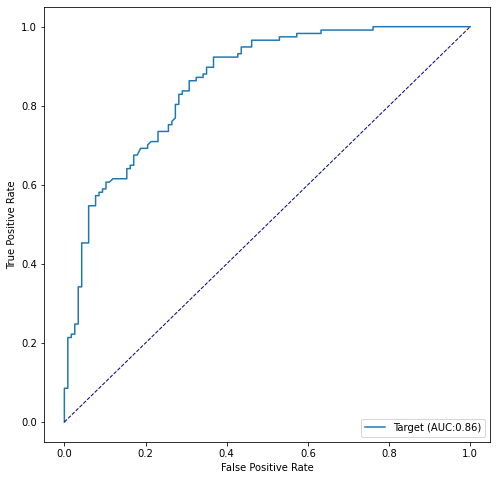

In [ ]:
plot_roc(y_t, y_p)
plt.legend(loc='lower right')

## Model 2

In [ ]:
TRAINING_FILENAMES = tf.io.gfile.glob('/content/tfrecords/train*.tfrec')

print('There are', len(TRAINING_FILENAMES) ,'train tf records')
print('There are', count_data_items(TRAINING_FILENAMES) ,'train images')

print(" ")

VALIDATION_FILENAMES = tf.io.gfile.glob('/content/tfrecords/val*.tfrec')

print('There are', len(VALIDATION_FILENAMES) ,'val tf records')
print('There are', count_data_items(VALIDATION_FILENAMES) ,'val images')

There are 5 train tf records
There are 934 train images
 
There are 2 val tf records
There are 234 val images


In [ ]:
BATCH_SIZE = 4 # reduce batch size, otherwise we get an out of memory error
training_dataset = get_training_dataset(BATCH_SIZE)
validation_dataset = get_validation_dataset(BATCH_SIZE)

In [ ]:
steps_per_epoch = count_data_items(TRAINING_FILENAMES)/BATCH_SIZE//REPLICAS
print("steps_per_epoch", steps_per_epoch)

steps_per_epoch 233.0


In [ ]:
OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy'
METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
] 

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
K.clear_session()
with strategy.scope():
    base_model.trainable = True
    model.summary()
    OPTIMIZER = tf.keras.optimizers.Adam(1e-5) # train with a very low learning rate
    model.compile(
        loss=LOSS,
        metrics=METRICS,
        optimizer=OPTIMIZER,
    )

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 768, 768, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 768, 768, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 768, 768, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 768, 768, 3)       0         
_________________________________________________________________
resnet101v2 (Functional)     (None, 24, 24, 2048)      42626560  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [ ]:
history = model.fit(
    training_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    verbose=VERBOSE_LEVEL
)

Epoch 1/30
233/233 [==============================] - 182s 511ms/step - loss: 0.4118 - tp: 198.9060 - fp: 55.6752 - tn: 177.1325 - fn: 38.2692 - accuracy: 0.8134 - precision: 0.8037 - recall: 0.8501 - auc: 0.8879 - val_loss: 0.4589 - val_tp: 97.0000 - val_fp: 33.0000 - val_tn: 84.0000 - val_fn: 20.0000 - val_accuracy: 0.7735 - val_precision: 0.7462 - val_recall: 0.8291 - val_auc: 0.8577

Epoch 00001: val_loss did not improve from 0.45891
Epoch 2/30
233/233 [==============================] - 114s 491ms/step - loss: 0.4854 - tp: 196.0556 - fp: 62.8974 - tn: 179.8376 - fn: 31.1923 - accuracy: 0.7938 - precision: 0.7474 - recall: 0.8625 - auc: 0.8574 - val_loss: 0.4589 - val_tp: 97.0000 - val_fp: 33.0000 - val_tn: 84.0000 - val_fn: 20.0000 - val_accuracy: 0.7735 - val_precision: 0.7462 - val_recall: 0.8291 - val_auc: 0.8577

Epoch 00002: val_loss did not improve from 0.45891
Epoch 3/30
233/233 [==============================] - 111s 475ms/step - loss: 0.4448 - tp: 195.9658 - fp: 53.2821 - 

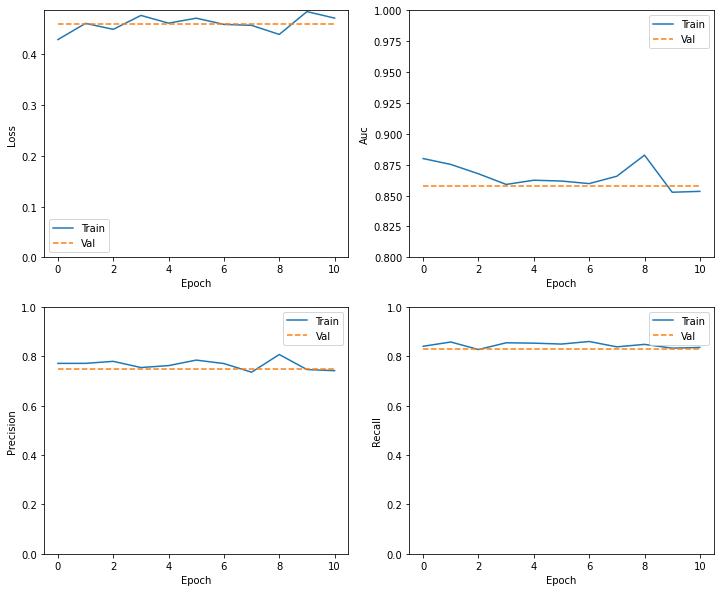

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
plot_metrics(history)

In [ ]:
y_t = []  # true labels
y_p = []  # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(validation_set_balanced.shape[0])):
    y_true = validation_set_balanced.iloc[i].target_1
    image_path = validation_set_balanced.iloc[i].image_path

    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(DIM,DIM))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)

    y_t.append(y_true)
    y_p.append(y_pred[0][0])

100%|██████████| 234/234 [00:25<00:00,  9.10it/s]


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_t, y_p)
f1score = [calc_f1(precision[i], recall[i])
               for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)

Precision: 0.7152
Recall: 0.9231
Threshold: 0.3887
F1 Score: 0.806


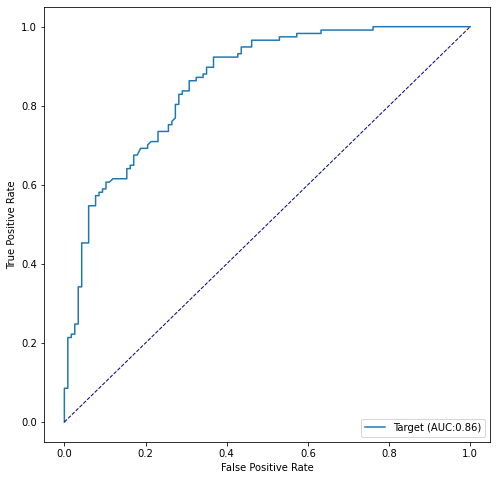

In [ ]:
plot_roc(y_t, y_p)
plt.legend(loc='lower right')

## Submission

In [ ]:
# create the submission.csv file
data=[]
for i in tqdm(range(test_set.shape[0])):
    image_path = test_set.iloc[i].image_path
    image_name = test_set.iloc[i].image_name

    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(DIM,DIM))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = y_pred[0][0]
    data.append([image_name, y_pred])

sub_df = pd.DataFrame(data, columns = ['image_name', 'target']) 
sub_df.to_csv("./submission.csv", index=False)

sub_df.head()

!kaggle competitions submit -c siim-isic-melanoma-classification -f submission.csv -m "Sub"

  1%|          | 115/10982 [00:10<17:05, 10.60it/s]

TypeError: ignored